# Time Series Forecasting of German Automotive Stocks (VW, Porsche, BMW)

This notebook focuses on time series analysis and forecasting of stock prices for three major German automotive stocks — Volkswagen (VW), Porsche, and BMW — over the period **2016–2025**.  

The main objective is to build and compare models that can effectively predict stock prices based on past observations.  
Several forecasting models were applied and evaluated.

Additionally, for **Volkswagen**, a separate volatility analysis was conducted using a **GARCH(1,1)** model to study how return volatility behaved before and after a detected structural event (`ann_1`).

### Key Objectives:
- Data loading and preprocessing  
- Exploratory analysis and visualization  
- Model fitting and forecasting for each company  
- Volatility modeling for VW (GARCH analysis)  
- Comparative discussion of results


## Importing the Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data
Download daily stock prices of Volkswagen, Porsche, and BMW (2016–2025) using Yahoo Finance.  
Data is grouped by ticker.


In [5]:
raw_data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval = "1d",start= "2016-02-01" , end = "2025-10-29" ,group_by = 'ticker',
                              auto_adjust = True, threads = True)

[*********************100%***********************]  3 of 3 completed


In [6]:
data = raw_data.copy()
data.head()

Ticker         BMW.DE                                              VOW3.DE  \
Price            Open       High        Low      Close   Volume       Open   
Date                                                                         
2016-02-01  45.586284  45.651501  44.009234  44.744400  2236348  62.057773   
2016-02-02  44.596180  44.702898  43.689080  43.890656  1593641  61.277358   
2016-02-03  43.517143  44.353097  42.390677  43.102127  2686190  59.514191   
2016-02-04  42.752332  42.977623  41.133777  42.384747  3232030  59.254050   
2016-02-05  42.449962  43.783934  42.200955  42.930195  1967856  58.155672   

Ticker                                                  PAH3.DE             \
Price            High        Low      Close   Volume       Open       High   
Date                                                                         
2016-02-01  62.086680  60.121179  61.219547  1257806  29.112036  29.399828   
2016-02-02  61.392974  59.861044  60.005566  1010791  28.640477  28.744499   
2016-02-03  59.629811  57.895546  58.618156  1738313  27.825648  27.874191   
2016-02-04  59.311857  57.149809  58.386917  1792183  27.628007  27.856852   
2016-02-05  60.872689  57.577584  59.629799  2138944  27.385286  28.810373   

Ticker                                    
Price             Low      Close  Volume  
Date                                      
2016-02-01  28.096096  28.765299  444260  
2016-02-02  27.721623  27.884590  571767  
2016-02-03  26.664079  27.191118  959533  
2016-02-04  26.740361  27.520519  839359  
2016-02-05  27.385286  28.179312  787005

## Defining Analysis Periods
Set the overall analysis period from 2016-02-01 to 2025-10-29,  
with a key event on 2020-01-01 to split the data for pre- and post-event analysis.


In [8]:
# Starting Date
start_date = "2016-02-01" 


# First key event
ann_1 = "2020-01-01" 


#Ending Date
end_date = "2025-10-29"


## Preparing the Data
- Extracted daily closing prices for Volkswagen, Porsche, and BMW.  
- Calculated daily returns (%) and squared returns to analyze volatility patterns.


In [10]:
# Extracting Closing Prices
data['vol'] = raw_data['VOW3.DE'].Close
data['por'] = raw_data['PAH3.DE'].Close
data['bmw'] = raw_data['BMW.DE'].Close

# Creating Returns
data['ret_vol'] = data['vol'].pct_change(1).mul(100)
data['ret_por'] = data['por'].pct_change(1).mul(100)
data['ret_bmw'] = data['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
data['sq_vol'] = data.ret_vol.mul(data.ret_vol)
data['sq_por'] = data.ret_por.mul(data.ret_por)
data['sq_bmw'] = data.ret_bmw.mul(data.ret_bmw)


## Data Cleaning and Frequency Assignment
- Set the data frequency to business days and backfilled missing values.  
- Removed unusfull columns from the original dataset to keep only relevant features.


In [12]:
# Assigning the Frequency and Filling NA Values
data = data.asfreq('b')
data = data.fillna(method='bfill')

In [13]:
# Removing Surplus Data
data = data.drop(["BMW.DE","PAH3.DE","VOW3.DE"] , axis = 1)

In [14]:
data.isna().sum()

Ticker   Price
vol               0
por               0
bmw               0
ret_vol           0
ret_por           0
ret_bmw           0
sq_vol            0
sq_por            0
sq_bmw            0
dtype: int64

## Visualizing Stock Prices
Plotted the closing prices of Volkswagen (green), Porsche (red), and BMW (blue) from the start to the end date.


<Axes: xlabel='Date'>

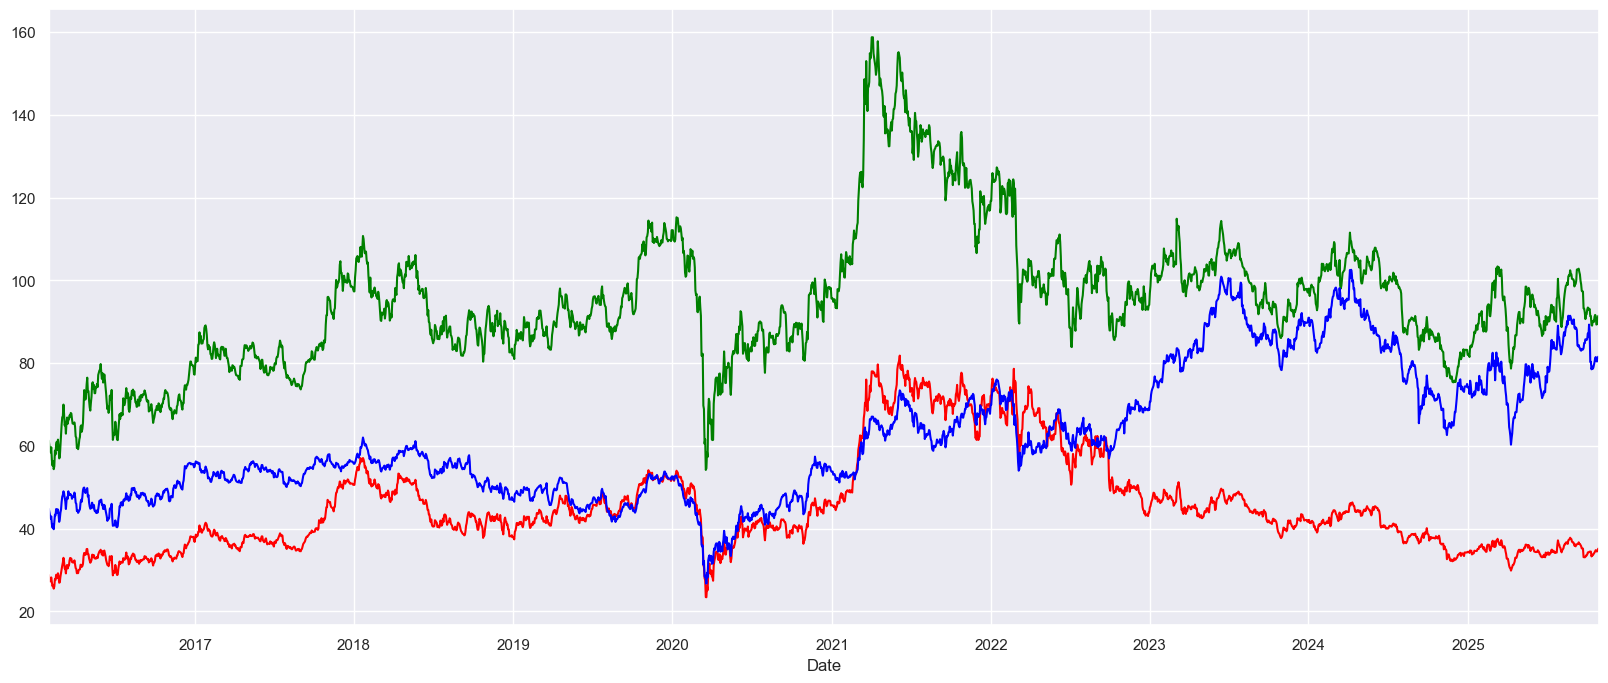

In [16]:
data["vol"][start_date : end_date].plot(figsize = (20,8) , color = "green")
data["por"][start_date : end_date].plot( color = "red")
data["bmw"][start_date : end_date].plot( color = "blue")

## Correlation Analysis
- Calculated correlations between Volkswagen, Porsche, and BMW closing prices for different periods: before the key event and after the key event  and the full period.
- Observed that Volkswagen and Porsche are highly correlated, while BMW shows weaker correlation with the other two.


In [18]:
print('Volkswagen and Porsche correlation: \t'+ str(data['vol'][start_date:ann_1].corr(data['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(data['vol'][start_date:ann_1].corr(data['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(data['por'][start_date:ann_1].corr(data['bmw'][start_date:end_date])))

Volkswagen and Porsche correlation: 	0.9780881204907881
Volkswagen and BMW correlation: 	0.4834483899670402
Porsche and BMW correlation: 		0.5070543891375884


In [19]:
print('Volkswagen and Porsche correlation: \t'+ str(data['vol'][ann_1 : end_date].corr(data['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(data['vol'][ann_1 : end_date].corr(data['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(data['por'][ann_1 : end_date].corr(data['bmw'][start_date:end_date])))

Volkswagen and Porsche correlation: 	0.8453088149307022
Volkswagen and BMW correlation: 	0.1743712785512172
Porsche and BMW correlation: 		-0.11012111076061794


In [20]:
print('Volkswagen and Porsche correlation: \t'+ str(data['vol'][start_date:end_date].corr(data['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(data['vol'][start_date:end_date].corr(data['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(data['por'][start_date:end_date].corr(data['bmw'][start_date:end_date])))

Volkswagen and Porsche correlation: 	0.8718992659637544
Volkswagen and BMW correlation: 	0.41114007695786736
Porsche and BMW correlation: 		0.13988515229594395


## Auto-ARIMA Modeling for Stock Prices

- Built Auto-ARIMA models for Volkswagen, Porsche, and BMW closing prices using exogenous variables.
- For each stock (Volkswagen, Porsche, BMW), three Auto-ARIMA models were trained:  
  1. From `start_date` to the first announcement (`ann_1`)  
  2. From `ann_1` to `end_date`  
  3. From `start_date` to `end_date` (full period)  
- This approach allows analyzing stock behavior before, after, and across the entire period of the key event.


### For Volkswagen

In [23]:
model_vol_1 = auto_arima(data.vol[start_date:ann_1], X = data[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
model_vol_2 = auto_arima(data.vol[ann_1:end_date], X = data[['por','bmw']][ann_1:end_date],
                            m = 5, max_p = 5, max_q = 5)
model_vol_3 = auto_arima(data.vol[start_date:end_date], X = data[['por','bmw']][start_date:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [24]:
model_vol_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1023
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood                -904.185
Date:                           Sun, 02 Nov 2025   AIC                           1822.369
Time:                                   00:19:51   BIC                           1856.876
Sample:                               02-01-2016   HQIC                          1835.470
                                    - 01-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7098      0.029     59.224      0.000       1.653       1.766
bmw            0.3322      0.036      9.322      0.000       0.262       0.402
ar.L1          0.5521      0.168      3.296      0.001       0.224       0.880
ma.L1         -0.6436      0.156     -4.127      0.000      -0.949      -0.338
ar.S.L5       -0.9258      0.064    -14.395      0.000      -1.052      -0.800
ma.S.L5        0.8915      0.076     11.775      0.000       0.743       1.040
sigma2         0.3435      0.012     29.271      0.000       0.320       0.366
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               102.63
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.15
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
model_vol_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1520
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2258.198
Date:                Sun, 02 Nov 2025   AIC                           4524.395
Time:                        00:19:51   BIC                           4545.698
Sample:                    01-01-2020   HQIC                          4532.326
                         - 10-28-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.2410      0.019     65.396      0.000       1.204       1.278
bmw            0.5187      0.020     25.355      0.000       0.479       0.559
ma.L1         -0.0981      0.011     -8.900      0.000      -0.120      -0.077
sigma2         1.1450      0.017     67.190      0.000       1.112       1.178
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12693.08
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
model_vol_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2542
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 5)   Log Likelihood               -3384.216
Date:                           Sun, 02 Nov 2025   AIC                           6780.432
Time:                                   00:19:51   BIC                           6815.474
Sample:                               02-01-2016   HQIC                          6793.144
                                    - 10-28-2025                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.3125      0.013     98.237      0.000       1.286       1.339
bmw            0.5020      0.015     33.964      0.000       0.473       0.531
ma.L1         -0.0951      0.008    -11.662      0.000      -0.111      -0.079
ar.S.L5        0.6576      0.222      2.962      0.003       0.222       1.093
ma.S.L5       -0.6912      0.212     -3.263      0.001      -1.106      -0.276
sigma2         0.8401      0.009     92.996      0.000       0.822       0.858
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             28678.74
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### For Porsche

In [28]:
model_por_1 = auto_arima(data.por[start_date:ann_1], X = data[['vol']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
model_por_2 = auto_arima(data.por[ann_1:end_date], X = data[['vol']][ann_1:end_date],
                            m = 5, max_p = 5, max_q = 5)
model_por_3 = auto_arima(data.por[start_date:end_date], X = data[['vol']][start_date:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [29]:
model_por_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1023
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 5)   Log Likelihood                -149.740
Date:                           Sun, 02 Nov 2025   AIC                            311.480
Time:                                   00:21:58   BIC                            341.057
Sample:                               02-01-2016   HQIC                           322.710
                                    - 01-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.4208      0.005     81.657      0.000       0.411       0.431
ar.L1          0.5927      0.171      3.472      0.001       0.258       0.927
ma.L1         -0.6753      0.157     -4.310      0.000      -0.982      -0.368
ar.S.L5       -0.9483      0.038    -25.097      0.000      -1.022      -0.874
ma.S.L5        0.9086      0.050     18.066      0.000       0.810       1.007
sigma2         0.0784      0.002     31.557      0.000       0.074       0.083
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               221.60
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model_por_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1520
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1422.221
Date:                Sun, 02 Nov 2025   AIC                           2856.442
Time:                        00:21:58   BIC                           2888.397
Sample:                    01-01-2020   HQIC                          2868.339
                         - 10-28-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.4356      0.003    138.691      0.000       0.429       0.442
ar.L1         -0.0828      0.068     -1.209      0.226      -0.217       0.051
ar.L2          0.8306      0.055     15.179      0.000       0.723       0.938
ma.L1          0.0327      0.068      0.482      0.630      -0.100       0.166
ma.L2         -0.8437      0.051    -16.541      0.000      -0.944      -0.744
sigma2         0.3809      0.006     69.193      0.000       0.370       0.392
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              9196.14
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
model_por_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2542
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1893.444
Date:                Sun, 02 Nov 2025   AIC                           3798.887
Time:                        00:21:58   BIC                           3833.929
Sample:                    02-01-2016   HQIC                          3811.599
                         - 10-28-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.4322      0.002    203.838      0.000       0.428       0.436
ar.L1         -0.0985      0.047     -2.087      0.037      -0.191      -0.006
ar.L2          0.8169      0.037     21.818      0.000       0.743       0.890
ma.L1          0.0458      0.047      0.980      0.327      -0.046       0.137
ma.L2         -0.8334      0.035    -23.892      0.000      -0.902      -0.765
sigma2         0.2599      0.003    103.073      0.000       0.255       0.265
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             28510.67
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### For BMW

In [33]:
model_bmw_1 = auto_arima(data.bmw[start_date:ann_1], X = data[['vol']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
model_bmw_2 = auto_arima(data.bmw[ann_1:end_date], m = 5, max_p = 5, max_q = 5)

model_bmw_3 = auto_arima(data.bmw[start_date:end_date], X = data[['vol']][start_date:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [34]:
model_bmw_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1023
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 5)   Log Likelihood                -598.100
Date:                             Sun, 02 Nov 2025   AIC                           1208.200
Time:                                     00:22:38   BIC                           1237.777
Sample:                                 02-01-2016   HQIC                          1219.429
                                      - 01-01-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.3413      0.007     48.192      0.000       0.327       0.355
ar.L1          0.0913      0.028      3.276      0.001       0.037       0.146
ar.L2          0.0444      0.029      1.516      0.129      -0.013       0.102
ar.S.L5       -0.8085      0.161     -5.015      0.000      -1.125      -0.493
ma.S.L5        0.7649      0.177      4.313      0.000       0.417       1.112
sigma2         0.1887      0.006     31.937      0.000       0.177       0.200
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               210.76
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
model_bmw_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1520
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood               -2466.178
Date:                             Sun, 02 Nov 2025   AIC                           4936.357
Time:                                     00:22:38   BIC                           4947.008
Sample:                                 01-01-2020   HQIC                          4940.322
                                      - 10-28-2025                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L5        0.0532      0.024      2.183      0.029       0.005       0.101
sigma2         1.5056      0.034     44.564      0.000       1.439       1.572
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               748.77
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
model_bmw_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2542
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2821.210
Date:                Sun, 02 Nov 2025   AIC                           5646.420
Time:                        00:22:38   BIC                           5658.101
Sample:                    02-01-2016   HQIC                          5650.657
                         - 10-28-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.3901      0.005     78.075      0.000       0.380       0.400
sigma2         0.5394      0.006     86.927      0.000       0.527       0.552
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):             10951.04
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               4.66   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Future Forecasting

Predictions were generated for the period following the key event (`ann_1`) up to the end of the dataset (`end_date`).  
The models for Volkswagen, Porsche, and BMW were used to forecast returns, and the predicted values were compared with the actual observed prices in the same period.  

The following plots illustrate predicted vs actual prices for each stock:
- **Volkswagen** (vw)
- **Porsche** (por)
- **BMW**


### For Volkswagen

Text(0.5, 1.0, 'VW Predictions vs Real Data')

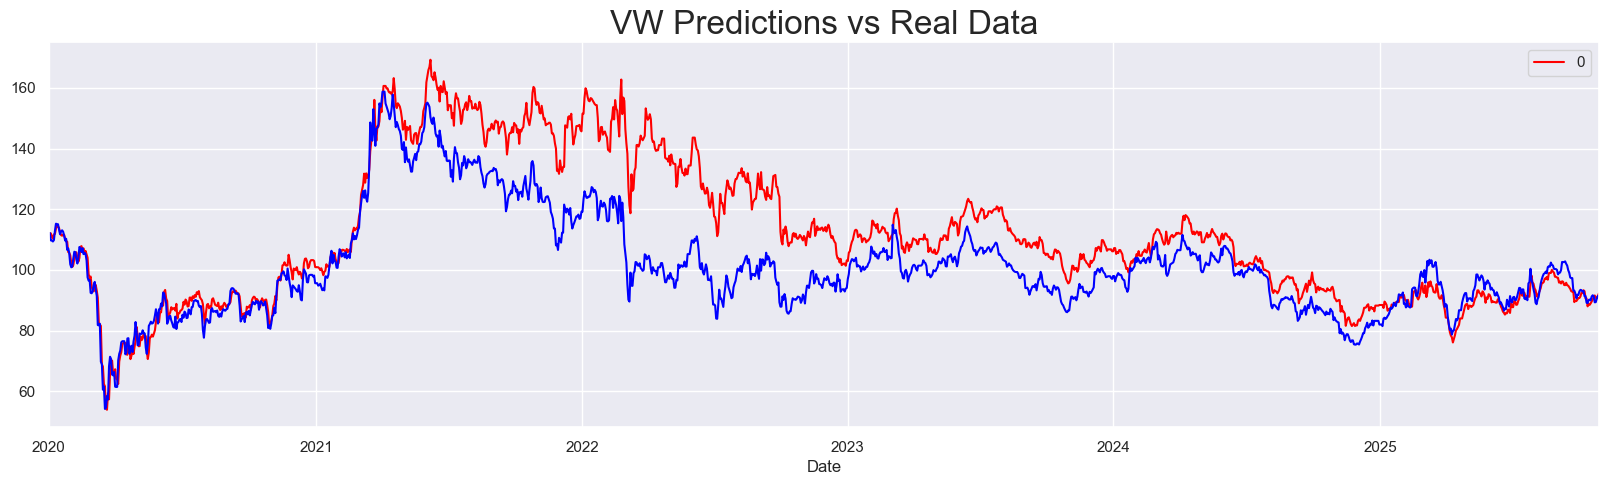

In [39]:
data_pred_1 = pd.DataFrame(model_vol_1.predict(n_periods = len(data[ann_1 : end_date]),X = data[['por','bmw']][ann_1 : end_date]), index = data[ann_1 : end_date].index)
data_pred_1[ann_1 : end_date].plot(figsize = (20,5), color = "red")

data.vol[ann_1 : end_date].plot(color = "blue")
plt.title("VW Predictions vs Real Data", size = 24)


### For Porche

Text(0.5, 1.0, 'Porche Predictions vs Real Data')

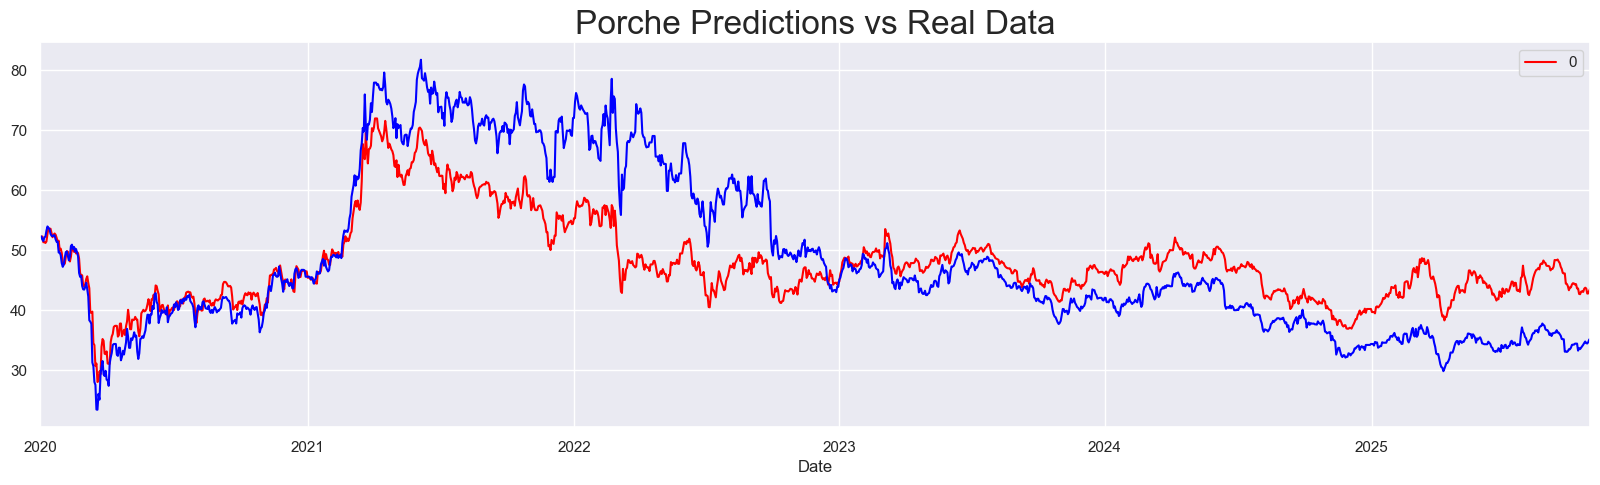

In [41]:
data_pred_por = pd.DataFrame(model_por_1.predict(n_periods = len(data[ann_1 : end_date]),X = data[['vol']][ann_1 : end_date]), index = data[ann_1 : end_date].index)
data_pred_por[ann_1 : end_date].plot(figsize = (20,5), color = "red")

data.por[ann_1 : end_date].plot(color = "blue")
plt.title("Porche Predictions vs Real Data", size = 24)



### For BMW

Text(0.5, 1.0, 'BMw Predictions vs Real Data')

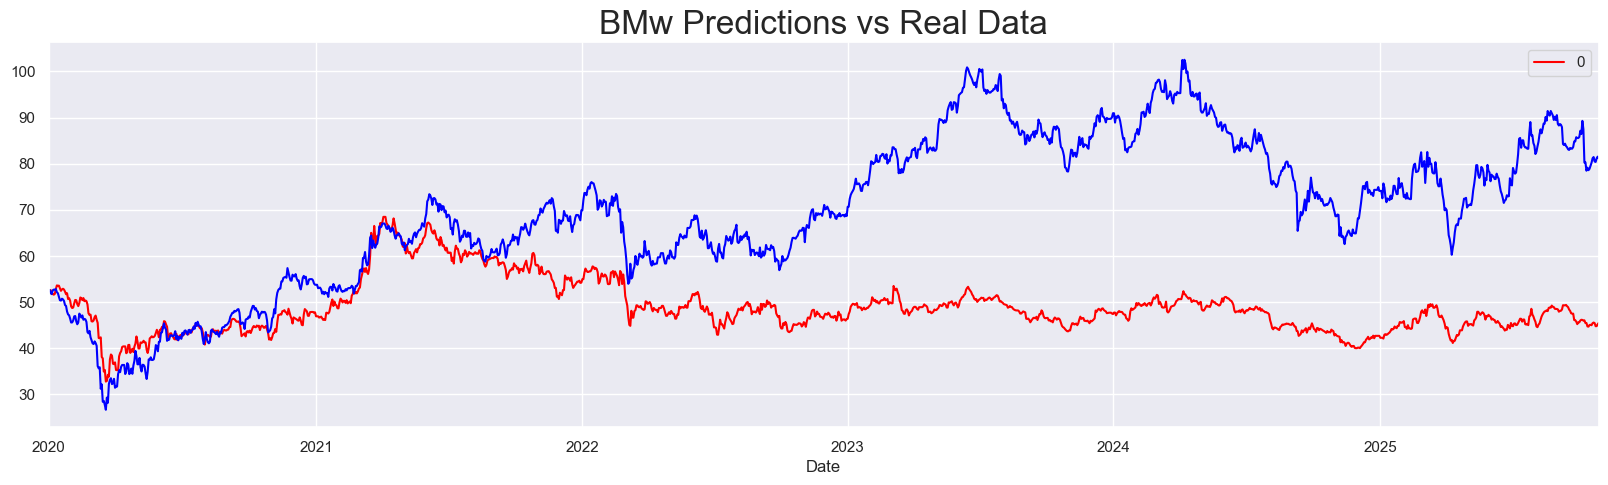

In [43]:
data_pred_bmw = pd.DataFrame(model_bmw_1.predict(n_periods = len(data[ann_1 : end_date]),X = data[['vol']][ann_1 : end_date]), index = data[ann_1 : end_date].index)
data_pred_bmw[ann_1 : end_date].plot(figsize = (20,5), color = "red")

data.bmw[ann_1 : end_date].plot(color = "blue")
plt.title("BMw Predictions vs Real Data", size = 24)



## Volatility

## Volatility Analysis

The volatility of each stock was measured using squared returns (`return^2`).  

For each stock, the squared returns are plotted for two periods:
1. From `start_date` to `ann_1` (light color)  
2. From `ann_1` to `end_date` (dark color)  

These plots illustrate how volatility changed across the two periods.


### Volatility of Volkswagon

<Axes: xlabel='Date'>

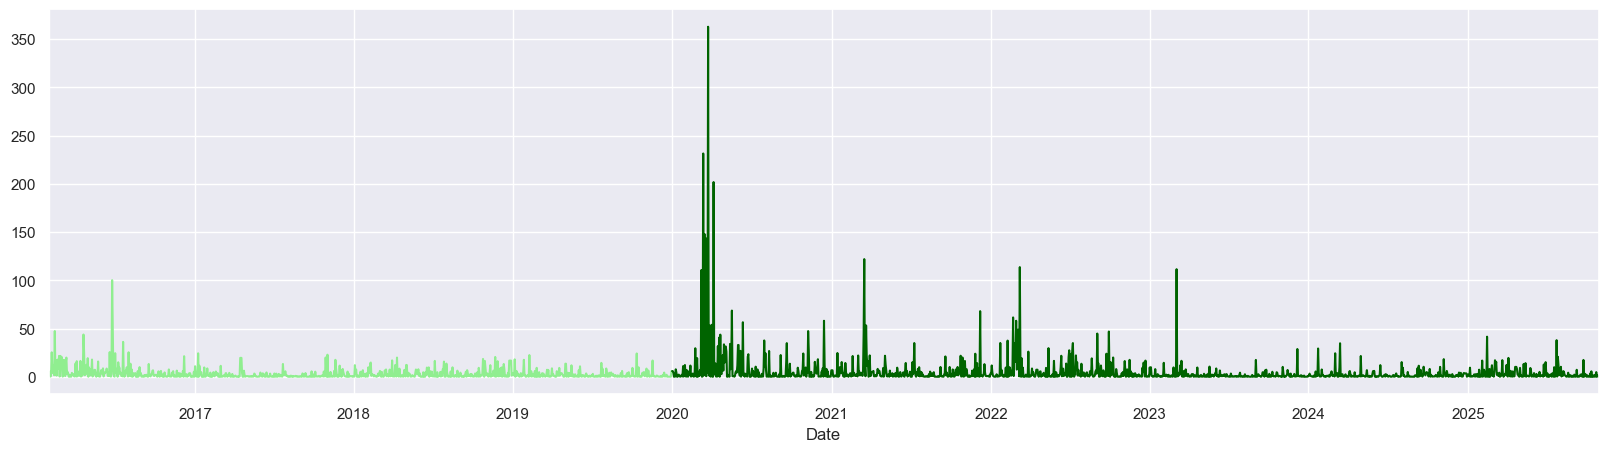

In [47]:
data['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = "#90EE90")
data['sq_vol'][ann_1:end_date].plot(color = "#006400")


### Volatility of Porche

<Axes: xlabel='Date'>

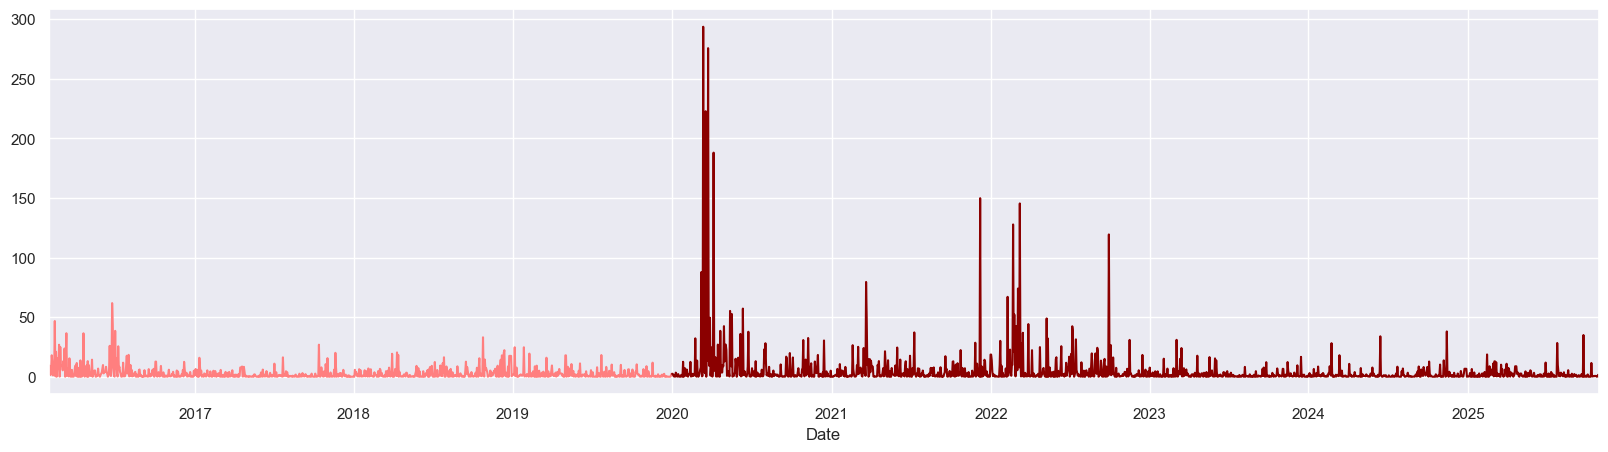

In [49]:
data['sq_por'][start_date:ann_1].plot(figsize = (20,5), color = "#FF7F7F")
data['sq_por'][ann_1:end_date].plot(color = "#8B0000")

### Volatility of BMW

<Axes: xlabel='Date'>

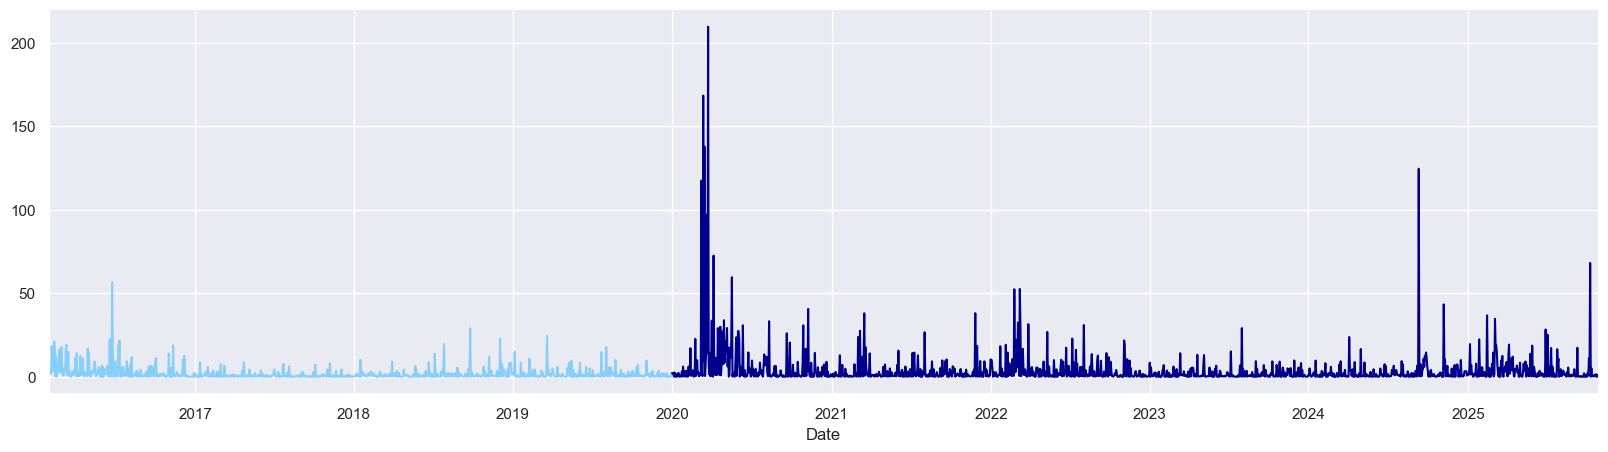

In [51]:
data['sq_bmw'][start_date:ann_1].plot(figsize = (20,5), color = "#87CEFA")
data['sq_bmw'][ann_1:end_date].plot(color = "#00008B")


## Volatility Modeling using GARCH ()

To capture the dynamic behavior of stock volatility, GARCH(1,1) models were fitted on daily returns of Volkswagen (vw) 

Three models were estimated:
1. **Period 1:** From `start_date` to `ann_1`  
2. **Period 2:** From `ann_1` to `end_date`  
3. **Full Period:** From `start_date` to `end_date`  


In [53]:
model_garch_vol_1 = arch_model(data.ret_vol[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_vol_1 = model_garch_vol_1.fit()

model_garch_vol_2 = arch_model(data.ret_vol[ann_1:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_vol_2 = model_garch_vol_2.fit()

model_garch_vol_3 = arch_model(data.ret_vol[start_date:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_vol_3 = model_garch_vol_3.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20526034722.47622
Iteration:      2,   Func. Count:     14,   Neg. LLF: 188674451345.1381
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2720.2730625817185
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1991.675764222161
Iteration:      5,   Func. Count:     39,   Neg. LLF: 1982.7834094781115
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1982.7834094812415
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1982.7834094781115
            Iterations: 6
            Function evaluations: 43
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      6,   Neg. LLF: 9167.911911984193
Iteration:      2,   Func. Count:     16,   Neg. LLF: 6946.4501050382005
Iteration:      3,   Func. Count:     23,   Neg. LLF: 12334.777544747445
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3754.1099492093254
Iteration:      5,   Func. Count:     37,   Neg. LLF: 3191.6023509

In [54]:
results_garch_vol_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1982.78
Distribution:                  Normal   AIC:                           3973.57
Method:            Maximum Likelihood   BIC:                           3993.29
                                        No. Observations:                 1023
Date:                Sun, Nov 02 2025   Df Residuals:                     1022
Time:                        00:22:39   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0915  4.990e-02      1.833  6.681e-02 [-6.339e-03,  0.189]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0637  5.368e-02      1.187      0.235 [-4.151e-02,  0.169]
alpha[1]       0.0523  3.263e-02      1.604      0.109 [-1.162e-02,  0.116]
beta[1]        0.9246  4.676e-02     19.773  5.100e-87    [  0.833,  1.016]
===========================================================================

Covariance estimator: robust
"""

In [55]:
results_garch_vol_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3182.57
Distribution:                  Normal   AIC:                           6373.14
Method:            Maximum Likelihood   BIC:                           6394.44
                                        No. Observations:                 1520
Date:                Sun, Nov 02 2025   Df Residuals:                     1519
Time:                        00:22:39   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0488  5.054e-02      0.965      0.335 [-5.028e-02,  0.148]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2084  9.751e-02      2.137  3.256e-02 [1.731e-02,  0.400]
alpha[1]       0.0982  3.070e-02      3.201  1.372e-03 [3.808e-02,  0.158]
beta[1]        0.8554  4.385e-02     19.507  9.557e-85   [  0.769,  0.941]
==========================================================================

Covariance estimator: robust
"""

In [56]:
results_garch_vol_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5167.90
Distribution:                  Normal   AIC:                           10343.8
Method:            Maximum Likelihood   BIC:                           10367.2
                                        No. Observations:                 2542
Date:                Sun, Nov 02 2025   Df Residuals:                     2541
Time:                        00:22:39   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0624  3.588e-02      1.740  8.190e-02 [-7.899e-03,  0.133]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1321  6.073e-02      2.176  2.958e-02 [1.310e-02,  0.251]
alpha[1]       0.0797  2.359e-02      3.376  7.343e-04 [3.342e-02,  0.126]
beta[1]        0.8858  3.478e-02     25.470 4.258e-143   [  0.818,  0.954]
==========================================================================

Covariance estimator: robust
"""

### Volkswagen Volatility Analysis

The GARCH(1,1) results indicate strong volatility persistence across all periods (β ≈ 0.9).  
Before the key event, volatility shocks were smaller and decayed more slowly.  
After the event, higher ω and α values show stronger and more frequent volatility movements.
